In [1]:
!pip install -U diffusers==0.14.0 transformers==4.27.4 scipy==1.10.0 accelerate==0.18.0

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 737.4/737.4 kB 6.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.8/6.8 MB 18.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 34.4/34.4 MB 35.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 215.3/215.3 kB 14.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 302.0/302.0 kB 26.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 108.1 MB/s eta 0:00:00
  Attempting uninstall: scipy
    Found existing installation: scipy 1.11.3
    Uninstalling scipy-1.11.3:
      Successfully uninstalled scipy-1.11.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
lida 0.0.10 requires fastapi, which is not installed.
lida 0.0.10 requires kaleido, which is not installed.
lida 0.0.10 requires python-multipart, which is not installed.
lida 0.0.10 req

In [12]:
import torch
from diffusers import StableDiffusionPipeline

device = "cuda"
model_id = "stabilityai/stable-diffusion-2-1-base"
pipe = StableDiffusionPipeline.from_pretrained(model_id, torch_dtype=torch.float16, revision="fp16")
vae = pipe.components["vae"].to(device)
tokenizer = pipe.components["tokenizer"]
text_encoder = pipe.components["text_encoder"].to(device)
unet = pipe.components["unet"].to(device)
scheduler = pipe.components["scheduler"]

Fetching 12 files:   0%|          | 0/12 [00:00<?, ?it/s]

Saving Screen Shot 2022-06-11 at 12.18.08.png to Screen Shot 2022-06-11 at 12.18.08.png


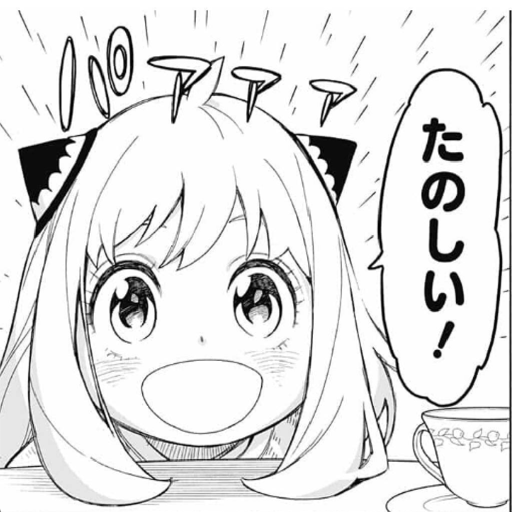

In [3]:
from google.colab import files
from PIL import Image

uploaded = files.upload()
for k in uploaded:
    start_img = Image.open(k).convert("RGB").resize((512, 512))

start_img

In [30]:
from torchvision import transforms

init_img = (transforms.ToTensor()(start_img).unsqueeze(0)*2.0 - 1.0).to(torch.float16).to(device)
with torch.no_grad():
    latent = vae.encode(init_img).latent_dist.sample()
    latent *= 0.18215

torch.manual_seed(50)
noise = torch.randn_like(latent)
total_step = 50
scheduler.set_timesteps(total_step)
print(scheduler.timesteps)

strength = 0.5
loop_start = int(total_step * (1 - strength))
start_step = torch.tensor(int(scheduler.timesteps[loop_start]), dtype=torch.int16)
noised_latent = scheduler.add_noise(latent, noise, start_step)

tensor([981, 961, 961, 941, 921, 901, 881, 861, 841, 821, 801, 781, 761, 741,
        721, 701, 681, 661, 641, 621, 601, 581, 561, 541, 521, 501, 481, 461,
        441, 421, 401, 381, 361, 341, 321, 301, 281, 261, 241, 221, 201, 181,
        161, 141, 121, 101,  81,  61,  41,  21,   1])


In [31]:
prompt = "blonde girl in ukiyoe art, hokusai style"
# prompt = "blonde girl in anime scene, saying fun in Japanese"
text_input = tokenizer(
    [prompt], padding="max_length", max_length=tokenizer.model_max_length, trancation=True,
    return_tensors="pt")
with torch.autocast(device):
    with torch.no_grad():
        text_embeddings = text_encoder(text_input.input_ids.to(device))[0]

max_length = text_input.input_ids.shape[-1]
uncond_input = tokenizer([""], padding="max_length", max_length=max_length,
                         return_tensors="pt")
uncond_embeddings = text_encoder(uncond_input.input_ids.to(device))[0]
text_embeddings = torch.cat([uncond_embeddings, text_embeddings])

Keyword arguments {'trancation': True} not recognized.


51it [00:03, 13.40it/s]


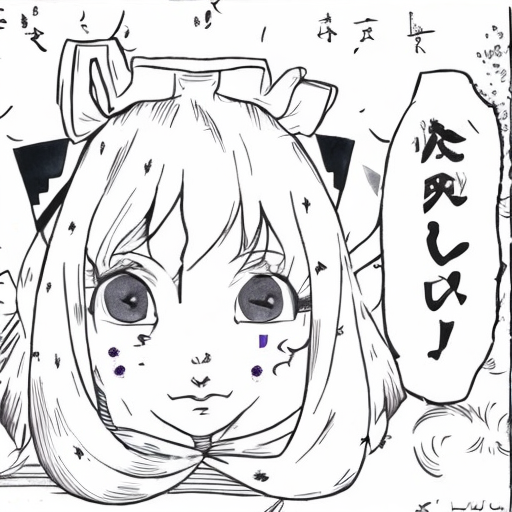

In [32]:
from tqdm import tqdm

CFG_scale = 7.5

latents = (noised_latent * scheduler.init_noise_sigma).to(device)

with torch.autocast(device):
    for i, t in tqdm(enumerate(scheduler.timesteps)):
        if i > loop_start:
            latent_model_input = torch.cat([latents] * 2)
            latent_mdoel_input = scheduler.scale_model_input(
                latent_model_input, timestep=t
            )

            with torch.no_grad():
                noise_pred = unet(latent_model_input, t, encoder_hidden_states=text_embeddings).sample

            noise_pred_uncond, noise_pred_text = noise_pred.chunk(2)
            res = noise_pred_text - noise_pred_uncond
            noise_pred = noise_pred_uncond ++ CFG_scale * res

            latents = scheduler.step(noise_pred, t, latents).prev_sample

with torch.no_grad():
    image = vae.decode(latents/0.18215).sample

image = (image/2 + 0.5).clamp(0, 1)
image = image.detach().cpu().permute(0, 2, 3, 1).numpy()
images = (image * 255).round().astype("uint8")
pil_images = [Image.fromarray(image) for image in images]

pil_images[0]

Keyword arguments {'trancation': True} not recognized.


0.1


Keyword arguments {'trancation': True} not recognized.


0.2


Keyword arguments {'trancation': True} not recognized.


0.3


Keyword arguments {'trancation': True} not recognized.


0.4


Keyword arguments {'trancation': True} not recognized.


0.5


Keyword arguments {'trancation': True} not recognized.


0.6


Keyword arguments {'trancation': True} not recognized.


0.7


Keyword arguments {'trancation': True} not recognized.


0.8


Keyword arguments {'trancation': True} not recognized.


0.9


Keyword arguments {'trancation': True} not recognized.


1.0


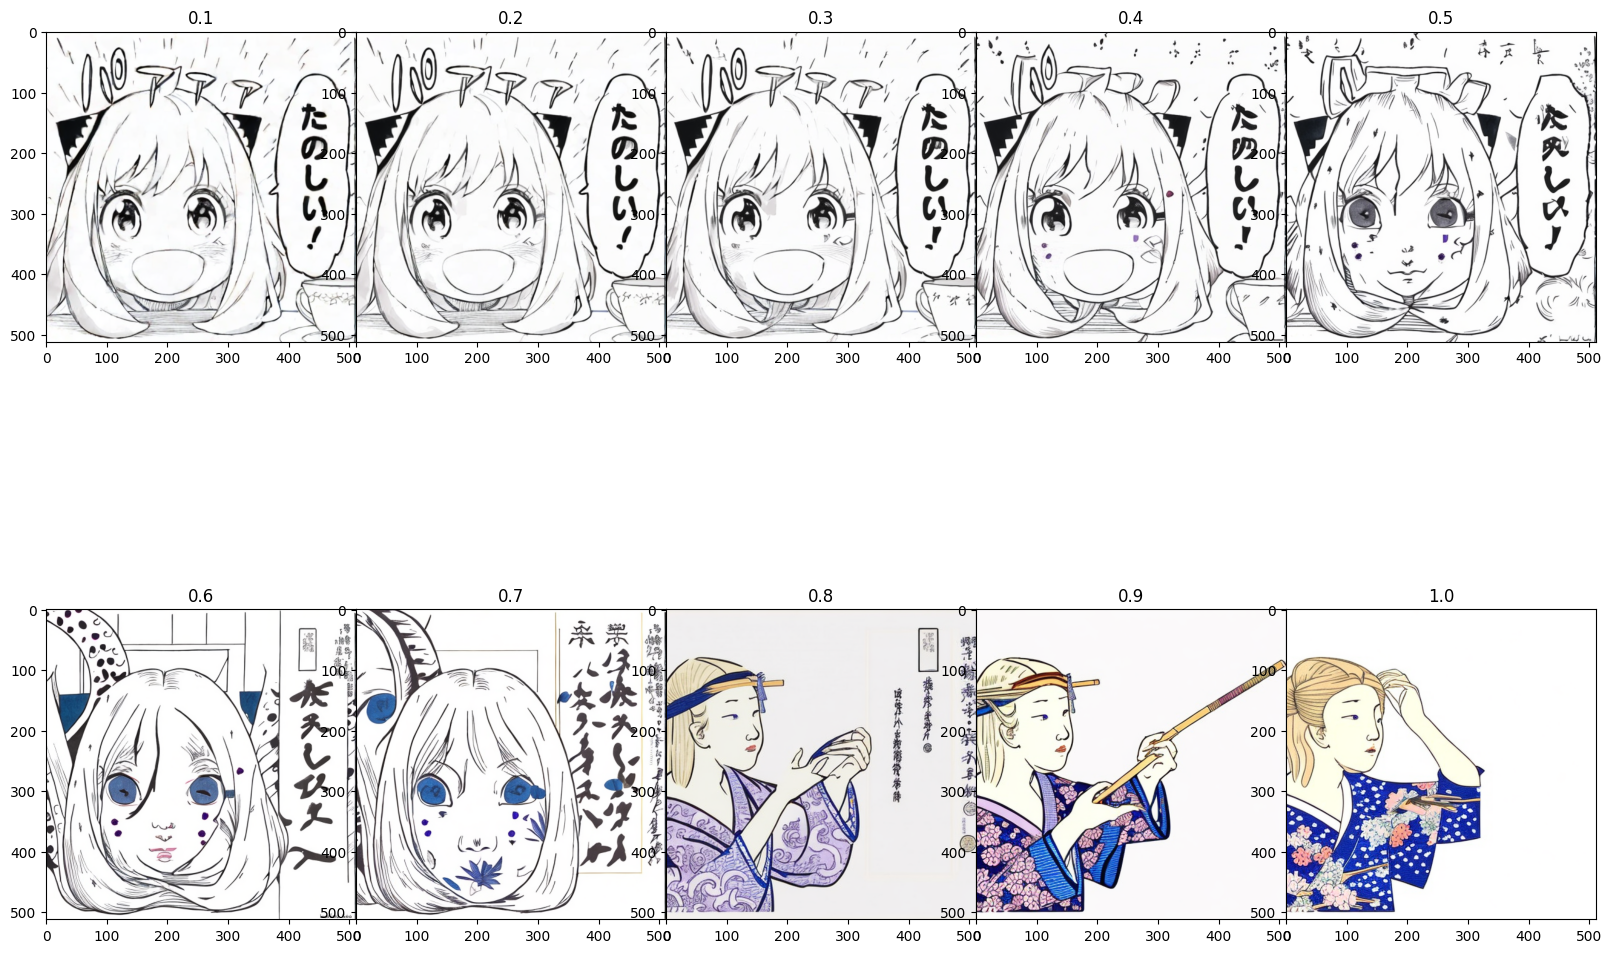

In [61]:
from torchvision import transforms
from tqdm import tqdm
import cv2
import matplotlib.pyplot as plt
from decimal import Decimal

plt.figure(figsize=(20, 15))
plt.subplots_adjust(wspace=0.0, hspace=0.0)

results = []
for strengthIndx in range(1, 11):
    strength = float(Decimal(str(strengthIndx)) * Decimal('0.1'))
    print(strength)

    init_img = (transforms.ToTensor()(start_img).unsqueeze(0)*2.0 - 1.0).to(torch.float16).to(device)
    with torch.no_grad():
        latent = vae.encode(init_img).latent_dist.sample()
        latent *= 0.18215

    torch.manual_seed(50)
    noise = torch.randn_like(latent)
    total_step = 50
    scheduler.set_timesteps(total_step)
    # print(scheduler.timesteps)

    loop_start = int(total_step * (1 - strength))
    start_step = torch.tensor(int(scheduler.timesteps[loop_start]), dtype=torch.int16)
    noised_latent = scheduler.add_noise(latent, noise, start_step)

    prompt = "blonde girl in ukiyoe art, hokusai style"
    # prompt = "blonde girl in anime scene, saying fun in Japanese"
    text_input = tokenizer(
        [prompt], padding="max_length", max_length=tokenizer.model_max_length, trancation=True,
        return_tensors="pt")
    with torch.autocast(device):
        with torch.no_grad():
            text_embeddings = text_encoder(text_input.input_ids.to(device))[0]

    max_length = text_input.input_ids.shape[-1]
    uncond_input = tokenizer([""], padding="max_length", max_length=max_length,
                            return_tensors="pt")
    uncond_embeddings = text_encoder(uncond_input.input_ids.to(device))[0]
    text_embeddings = torch.cat([uncond_embeddings, text_embeddings])


    CFG_scale = 7.5

    latents = (noised_latent * scheduler.init_noise_sigma).to(device)

    with torch.autocast(device):
        # for i, t in tqdm(enumerate(scheduler.timesteps)):
        for i, t in enumerate(scheduler.timesteps):
            if i > loop_start:
                latent_model_input = torch.cat([latents] * 2)
                latent_mdoel_input = scheduler.scale_model_input(
                    latent_model_input, timestep=t
                )

                with torch.no_grad():
                    noise_pred = unet(latent_model_input, t, encoder_hidden_states=text_embeddings).sample

                noise_pred_uncond, noise_pred_text = noise_pred.chunk(2)
                res = noise_pred_text - noise_pred_uncond
                noise_pred = noise_pred_uncond ++ CFG_scale * res

                latents = scheduler.step(noise_pred, t, latents).prev_sample

    with torch.no_grad():
        image = vae.decode(latents/0.18215).sample

    image = (image/2 + 0.5).clamp(0, 1)
    image = image.detach().cpu().permute(0, 2, 3, 1).numpy()
    images = (image * 255).round().astype("uint8")
    pil_images = [Image.fromarray(image) for image in images]

    pilloImage = pil_images[0]
    plt.subplot(2,5,strengthIndx)
    plt.title(str(strength))
    plt.imshow(pilloImage)

plt.show()

Keyword arguments {'trancation': True} not recognized.
Keyword arguments {'trancation': True} not recognized.
Keyword arguments {'trancation': True} not recognized.
Keyword arguments {'trancation': True} not recognized.
Keyword arguments {'trancation': True} not recognized.
Keyword arguments {'trancation': True} not recognized.
Keyword arguments {'trancation': True} not recognized.
Keyword arguments {'trancation': True} not recognized.
Keyword arguments {'trancation': True} not recognized.
Keyword arguments {'trancation': True} not recognized.


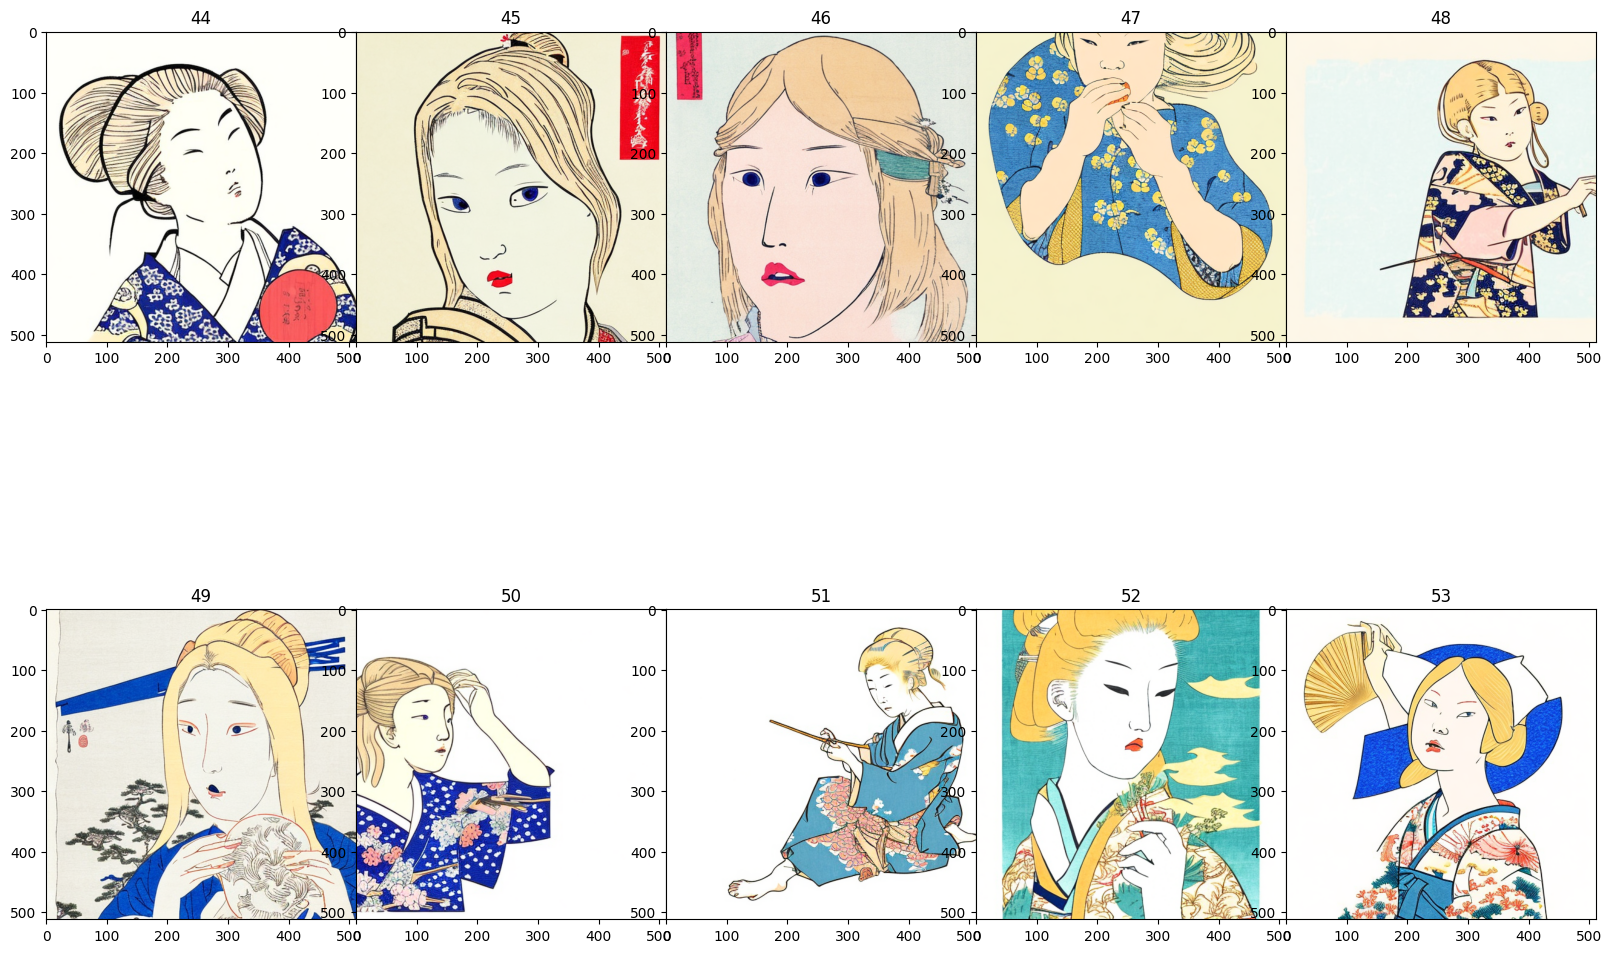

In [64]:
from torchvision import transforms
from tqdm import tqdm
import cv2
import matplotlib.pyplot as plt
from decimal import Decimal

plt.figure(figsize=(20, 15))
plt.subplots_adjust(wspace=0.0, hspace=0.0)

results = []
for seedLoopIndex in range(1, 11):
    seed = 43 + seedLoopIndex
    strength = 1.0

    init_img = (transforms.ToTensor()(start_img).unsqueeze(0)*2.0 - 1.0).to(torch.float16).to(device)
    with torch.no_grad():
        latent = vae.encode(init_img).latent_dist.sample()
        latent *= 0.18215

    torch.manual_seed(seed)
    noise = torch.randn_like(latent)
    total_step = 50
    scheduler.set_timesteps(total_step)
    # print(scheduler.timesteps)

    loop_start = int(total_step * (1 - strength))
    start_step = torch.tensor(int(scheduler.timesteps[loop_start]), dtype=torch.int16)
    noised_latent = scheduler.add_noise(latent, noise, start_step)

    prompt = "blonde girl in ukiyoe art, hokusai style"
    # prompt = "blonde girl in anime scene, saying fun in Japanese"
    text_input = tokenizer(
        [prompt], padding="max_length", max_length=tokenizer.model_max_length, trancation=True,
        return_tensors="pt")
    with torch.autocast(device):
        with torch.no_grad():
            text_embeddings = text_encoder(text_input.input_ids.to(device))[0]

    max_length = text_input.input_ids.shape[-1]
    uncond_input = tokenizer([""], padding="max_length", max_length=max_length,
                            return_tensors="pt")
    uncond_embeddings = text_encoder(uncond_input.input_ids.to(device))[0]
    text_embeddings = torch.cat([uncond_embeddings, text_embeddings])


    CFG_scale = 7.5

    latents = (noised_latent * scheduler.init_noise_sigma).to(device)

    with torch.autocast(device):
        # for i, t in tqdm(enumerate(scheduler.timesteps)):
        for i, t in enumerate(scheduler.timesteps):
            if i > loop_start:
                latent_model_input = torch.cat([latents] * 2)
                latent_mdoel_input = scheduler.scale_model_input(
                    latent_model_input, timestep=t
                )

                with torch.no_grad():
                    noise_pred = unet(latent_model_input, t, encoder_hidden_states=text_embeddings).sample

                noise_pred_uncond, noise_pred_text = noise_pred.chunk(2)
                res = noise_pred_text - noise_pred_uncond
                noise_pred = noise_pred_uncond ++ CFG_scale * res

                latents = scheduler.step(noise_pred, t, latents).prev_sample

    with torch.no_grad():
        image = vae.decode(latents/0.18215).sample

    image = (image/2 + 0.5).clamp(0, 1)
    image = image.detach().cpu().permute(0, 2, 3, 1).numpy()
    images = (image * 255).round().astype("uint8")
    pil_images = [Image.fromarray(image) for image in images]

    pilloImage = pil_images[0]
    plt.subplot(2,5,seedLoopIndex)
    plt.title(str(seed))
    plt.imshow(pilloImage)

plt.show()